# Visualize Simulation Data
This notebook loads in the simulated and original gene expression data used in `simulate_expresssion.py`, and looks at how similar they are

In [1]:
import copy
import json
import pickle
import os
import random 

import numpy as np
import pandas as pd
import umap
import tensorflow as tf
import yaml
from plotnine import *
from sklearn import preprocessing, decomposition

from saged import datasets, utils

In [2]:
# Set seeds
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
base_dir = '../..'
# This is hacky, but the config files in this project give relative paths from the base directory
os.chdir(base_dir)

## Look at learning curves

In [4]:
with open('data/simulated/sepsis_healthy_simulation_metadata.json') as in_file:
    metadata = json.load(in_file)

In [5]:
sepsis_train_loss = metadata['disease_loss']

epochs = list(range(len(sepsis_train_loss)))

metric_df = pd.DataFrame(sepsis_train_loss,
                         columns=['sepsis_loss', ])
metric_df['sepsis_val_loss'] = metadata['disease_val_loss']
metric_df['healthy_train_loss'] =  metadata['healthy_loss']
metric_df['healthy_val_loss'] = metadata['healthy_val_loss']
metric_df['epoch'] = epochs

metric_df = metric_df.melt(id_vars='epoch')

metric_df

,epoch,variable,value
0,0,sepsis_loss,8239.733929
1,1,sepsis_loss,7221.675809
2,2,sepsis_loss,7019.014216
3,3,sepsis_loss,6937.806566
4,4,sepsis_loss,6905.650151
...,...,...,...
395,95,healthy_val_loss,6807.425772
396,96,healthy_val_loss,6811.276663
397,97,healthy_val_loss,6808.146089
398,98,healthy_val_loss,6802.909419


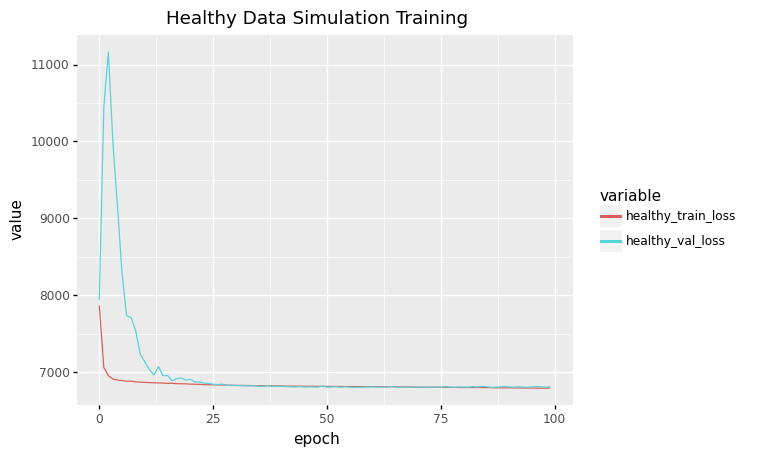

<ggplot: (8751762418273)>

In [6]:
healthy_df = metric_df[metric_df['variable'].str.contains('healthy')]
plot = ggplot(healthy_df, aes(x='epoch', y = 'value', color='variable'))
plot += geom_line()
plot += ggtitle('Healthy Data Simulation Training')
plot

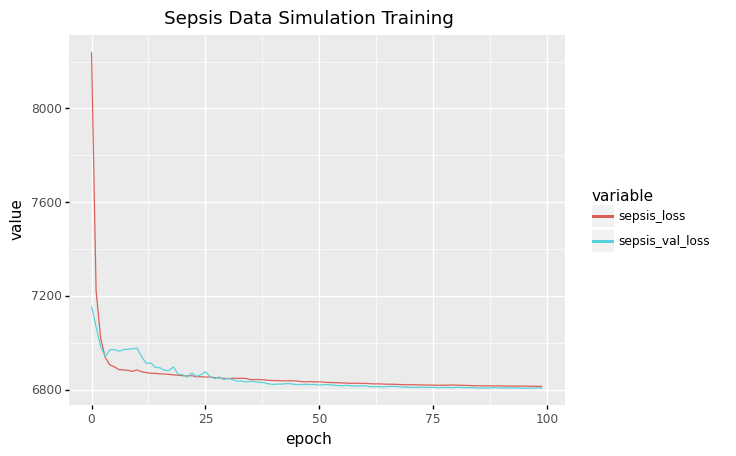

<ggplot: (8751461322813)>

In [7]:
sepsis_df = metric_df[metric_df['variable'].str.contains('sepsis')]
plot = ggplot(sepsis_df, aes(x='epoch', y = 'value', color='variable'))
plot += geom_line()
plot += ggtitle('Sepsis Data Simulation Training')
plot

## Load data used in training

In [8]:
sim_disease = np.loadtxt('data/simulated/sepsis_sim.tsv', delimiter='\t')
sim_healthy = np.loadtxt('data/simulated/sepsis_healthy_sim.tsv', delimiter='\t')
with open('data/simulated/sepsis_train.pkl', 'rb') as in_file:  
    disease_array = pickle.load(in_file)
with open('data/simulated/sepsis_healthy_train.pkl', 'rb') as in_file:
    healthy_array = pickle.load(in_file) 

In [9]:
print(disease_array.shape)
print(healthy_array.shape)
print(sim_disease.shape)
print(sim_healthy.shape)

(927, 14634)
(1574, 14634)
(1000, 14634)
(1000, 14634)


In [10]:
all_disease = np.concatenate([disease_array, sim_disease], axis=0)
all_healthy = np.concatenate([healthy_array, sim_healthy], axis=0)
print(all_disease.shape)
print(all_healthy.shape)

(1927, 14634)
(2574, 14634)


## Embed and plot data

In [11]:
reducer = umap.UMAP(random_state=42)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(1927, 2)

In [12]:
reducer = umap.UMAP(random_state=42)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [13]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['UMAP 1', 'UMAP 2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['UMAP 1', 'UMAP 2'])

In [14]:
disease_labels = ['real'] * disease_array.shape[0] + ['simulated'] * sim_disease.shape[0]
healthy_labels = ['real'] * healthy_array.shape[0] + ['simulated'] * sim_healthy.shape[0]

In [15]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

In [16]:
all_disease_df['alpha'] = 1
all_disease_df.loc[all_disease_df['Simulation or Real'] == 'simulated', 'alpha'] = .1
all_healthy_df['alpha'] = 1
all_healthy_df.loc[all_healthy_df['Simulation or Real'] == 'simulated', 'alpha'] = .1

In [17]:
all_disease_df

,UMAP 1,UMAP 2,Simulation or Real,alpha
0,8.650105,3.726485,real,1.0
1,8.185382,7.556231,real,1.0
2,3.161462,7.419904,real,1.0
3,8.148957,6.906099,real,1.0
4,7.731837,4.432100,real,1.0
...,...,...,...,...
1922,3.687750,6.362117,simulated,0.1
1923,2.505523,4.416052,simulated,0.1
1924,6.477335,6.127856,simulated,0.1
1925,7.664575,3.383482,simulated,0.1


In [18]:
all_healthy_df

,UMAP 1,UMAP 2,Simulation or Real,alpha
0,9.556990,11.689835,real,1.0
1,8.255298,12.830713,real,1.0
2,8.792512,8.900309,real,1.0
3,7.858478,11.832583,real,1.0
4,8.562399,12.265241,real,1.0
...,...,...,...,...
2569,8.349849,11.859341,simulated,0.1
2570,7.371578,10.034276,simulated,0.1
2571,7.256725,9.309318,simulated,0.1
2572,9.247725,11.061681,simulated,0.1


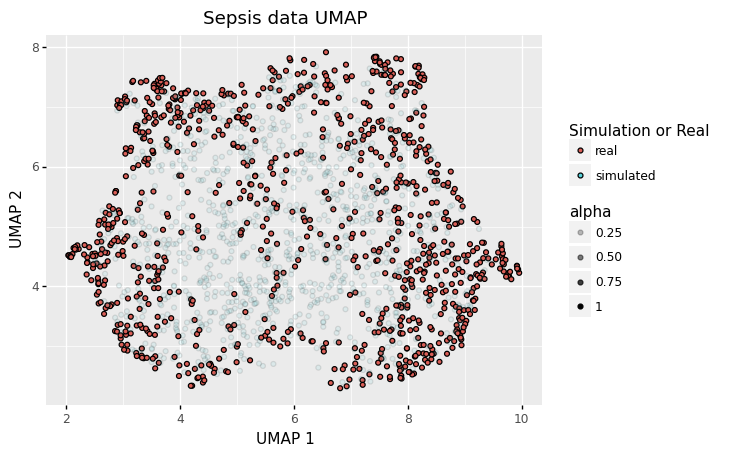

<ggplot: (8751440475745)>

In [19]:
(ggplot(all_disease_df, aes(x='UMAP 1', y='UMAP 2', 
                        fill='Simulation or Real', 
                        alpha='alpha')) + 
geom_point() +
ggtitle('Sepsis data UMAP'))

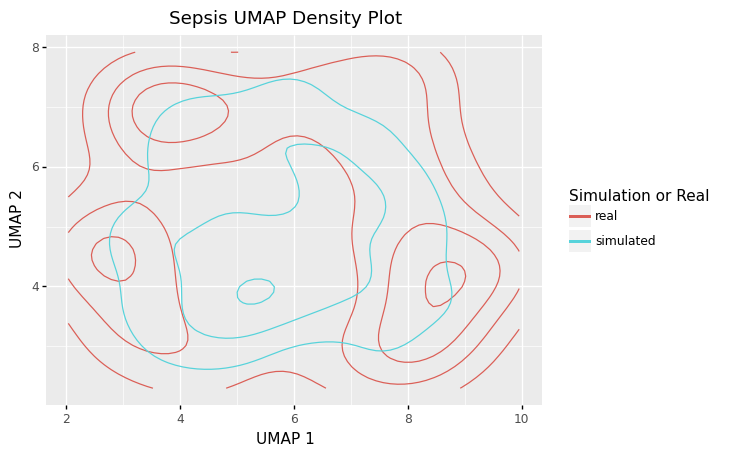

<ggplot: (8751461185233)>

In [20]:
(ggplot(all_disease_df, aes(x='UMAP 1', 
                           y='UMAP 2', 
                           color='Simulation or Real')) + 
geom_density_2d() +
ggtitle('Sepsis UMAP Density Plot'))

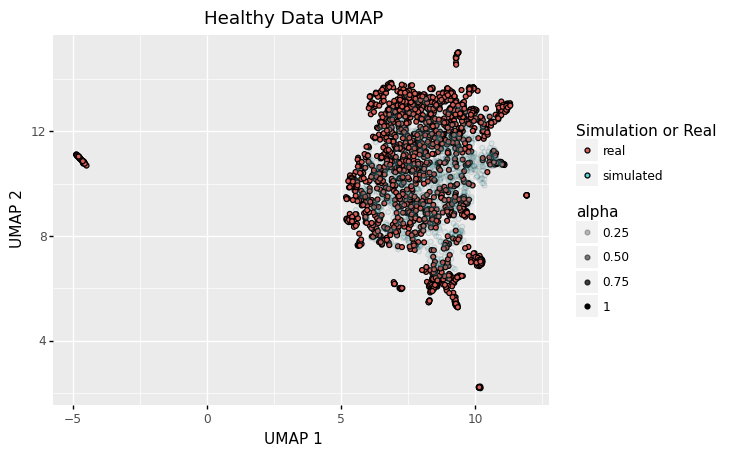

<ggplot: (8751461185225)>

In [21]:
(ggplot(all_healthy_df, aes(x='UMAP 1', y='UMAP 2', 
                           fill='Simulation or Real', 
                           alpha='alpha')) + 
geom_point() + 
ggtitle('Healthy Data UMAP'))

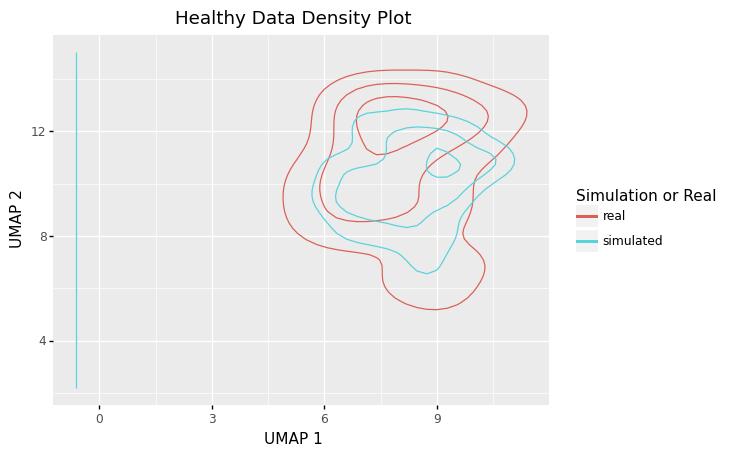

<ggplot: (8751457345697)>

In [22]:
(ggplot(all_healthy_df, aes(x='UMAP 1', 
                           y='UMAP 2', 
                           color='Simulation or Real')) + 
geom_density_2d() + 
ggtitle('Healthy Data Density Plot'))

In [23]:
real_healthy_pcs = all_healthy_df[all_healthy_df['Simulation or Real'] == 'real']
real_healthy_pcs['id'] = metadata['healthy_ids']
real_healthy_pcs[real_healthy_pcs['UMAP 1'] < 0]

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UMAP 1,UMAP 2,Simulation or Real,alpha,id
498,-4.549349,10.753037,real,1.0,GSM2630777
502,-4.692154,10.900817,real,1.0,GSM2630783
508,-4.599015,10.805381,real,1.0,GSM2630790
516,-4.757176,10.965099,real,1.0,GSM2630818
520,-4.596401,10.846168,real,1.0,GSM2630834
521,-4.630785,10.804625,real,1.0,GSM2630840
530,-4.807248,11.039435,real,1.0,GSM2630861
534,-4.551704,10.763920,real,1.0,GSM2630866
537,-4.844996,11.070001,real,1.0,GSM2630871
542,-4.499968,10.692074,real,1.0,GSM2630877


In [24]:
reducer = decomposition.PCA(n_components=2)
all_disease_umap = reducer.fit_transform(all_disease)
all_disease_umap.shape

(1927, 2)

In [25]:
reducer = decomposition.PCA(n_components=2)
all_healthy_umap = reducer.fit_transform(all_healthy)

In [26]:
all_disease_df = pd.DataFrame(all_disease_umap, columns=['PC1', 'PC2'])
all_healthy_df = pd.DataFrame(all_healthy_umap, columns=['PC1', 'PC2'])

In [27]:
all_disease_df['Simulation or Real'] = disease_labels
all_healthy_df['Simulation or Real'] = healthy_labels

In [28]:
all_disease_df['alpha'] = 1
all_disease_df.loc[all_disease_df['Simulation or Real'] == 'simulated', 'alpha'] = .1
all_healthy_df['alpha'] = 1
all_healthy_df.loc[all_healthy_df['Simulation or Real'] == 'simulated', 'alpha'] = .1

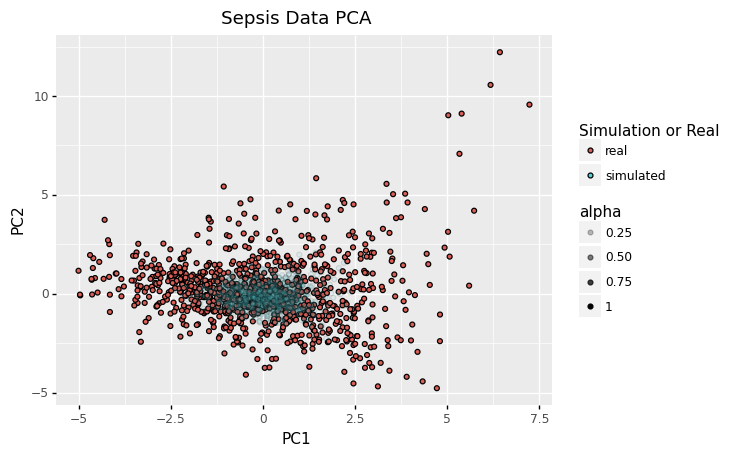

<ggplot: (8751461193557)>

In [29]:
(ggplot(all_disease_df, aes(x='PC1', y='PC2', 
                            fill='Simulation or Real', 
                            alpha='alpha')) + 
geom_point() + 
ggtitle('Sepsis Data PCA'))

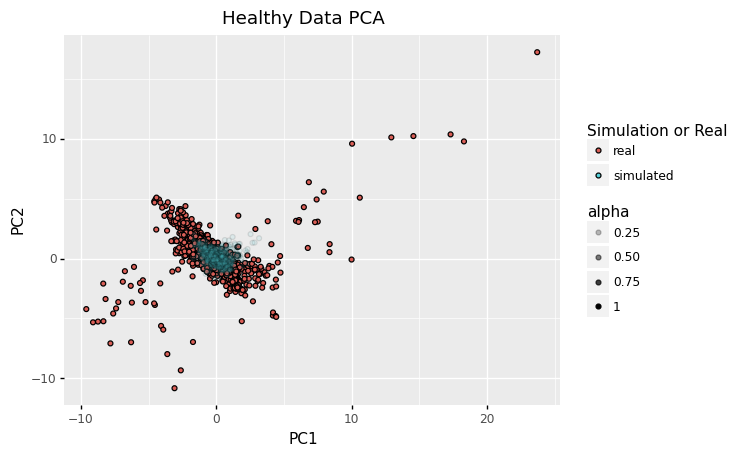

<ggplot: (8751446057681)>

In [30]:
(ggplot(all_healthy_df, aes(x='PC1', y='PC2', 
                            fill='Simulation or Real', 
                            alpha='alpha')) + 
geom_point() + 
ggtitle('Healthy Data PCA'))